# 空洞卷积(*Dilated/Atrous Convolution*或者是*Convolution with holes*)

Paper: https://arxiv.org/pdf/1511.07122.pdf

在标准的 convolution map 里注入空洞，以此来**增加 reception field**。dilation rate 指的是kernel的间隔数+1(e.g. 正常的 convolution 是 dilatation rate 1)。

**实现方法**：
* 从kernel角度：相当于在标准概念的kernel中，相邻点之间添加rate-1个0，然后使用扩张后的kernel与原图进行卷积。如下图rate=2，相当于标准的3*3卷积核变为5*5卷积核，每一行中间添加2-1个0
* 从原图角度：使用标准概念的kernel在原图中每隔rate-1进行像素点卷积采样。如下图rate=2，在原图中每隔rate-1进行卷积。

![Dilated Convolution with a 3 x 3 kernel and dilation rate 2](https://pic4.zhimg.com/50/v2-4959201e816888c6648f2e78cccfd253_hd.webp?source=1940ef5c)

**优点：**

* **可以增大感受野**
![空洞卷积（Atrous/Dilated Convolution）](https://www.pianshen.com/images/461/bc73037ac8cdfa94fde7176a981f1215.png)

* **不改变图像输出特征图的尺寸**
![](https://oscimg.oschina.net/oscnet/18f3c129-f302-4b8f-9d71-32cb52b3584c.jpg)
一维版的普通卷积(a、b)和空洞卷积(c),黑色的圆表示填充部分,a、b、c它们相互独立进行卷积

从b和c可以看出,有无空洞卷积,并不影响输出特征图的尺寸,也就是说输出特征图的尺和空洞数无关,因此可以利用空洞卷积增大感受野,而输出特征图的尺寸可以保持不变

* **捕获多尺度上下文信息。**空洞卷积有一个参数可以设置dilation rate，具体含义就是在卷积核中填充dilation rate-1个0，因此，当设置不同dilation rate时，感受野就会不一样，也即获取了多尺度信息。多尺度信息在视觉任务中相当重要

F*F的Feature map经过kernel size(k),padding(p), stride(s), rate(r) Dilated convolution卷积输出的大小$$out = ⌊\frac{F-[k+(k-1)(r-1)]+2p}{s}⌋+1$$

7*7的feature map，kernel size = 3, padding = 0,stride = 1,rate =2，标准卷积后大小F为$(7-3+0)/1+1 = 5$，Dilated卷积后大小F为$[7-(3+2*1)+0]/1+1=3$

In [14]:
import torch

input_value = torch.rand(1,1,7,7)
print('raw shape =',input_value.shape[1:])

standard_conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,stride=1)
standard_conv_output = standard_conv(input_value)
print('standard_conv shape =',standard_conv_output.shape[1:])

dilated_conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,stride=1,dilation=2)
dilated_conv_output = dilated_conv(input_value)
print('dilated_conv shape =',dilated_conv_output.shape[1:])

# 卷积核大小为3，空洞数为2的空洞卷积与卷积核大小为3+(3-1)*(2-1)=5的卷积核效果类似
dilated_conv2 = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5,stride=1)
dilated_conv_output2 = dilated_conv(input_value)
print('dilated_conv2 shape =',dilated_conv_output2.shape[1:])

raw shape = torch.Size([1, 7, 7])
standard_conv shape = torch.Size([1, 5, 5])
dilated_conv shape = torch.Size([1, 3, 3])
dilated_conv2 shape = torch.Size([1, 3, 3])


In [34]:
import numpy as np
from torchvision.transforms import Compose,ToTensor
from torch import nn
import torch.nn.init as init

def transform():
    return Compose([
        ToTensor(),
    ])

arr = range(1,26)
arr = np.reshape(arr,[5,5])
arr = np.expand_dims(arr,2).astype(np.float32)
print(arr.shape)
arr = transform()(arr)
arr = arr.unsqueeze(0)
print(arr.shape)
print(arr)
print('\n')

conv1 = nn.Conv2d(1,1,3,stride=1,bias=False,dilation=1)
conv2 = nn.Conv2d(1,1,3,stride=1,bias=False,dilation=2)
init.constant_(conv1.weight,1)
init.constant_(conv2.weight,1)
out1 = conv1(arr)
out2 = conv2(arr)
print('standare conv:\n', out1.detach().numpy())
print('dilated conv:\n', out2.detach().numpy())

(5, 5, 1)
torch.Size([1, 1, 5, 5])
tensor([[[[ 1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10.],
          [11., 12., 13., 14., 15.],
          [16., 17., 18., 19., 20.],
          [21., 22., 23., 24., 25.]]]])


standare conv:
 [[[[ 63.  72.  81.]
   [108. 117. 126.]
   [153. 162. 171.]]]]
dilated conv:
 [[[[117.]]]]


![out](https://img-blog.csdnimg.cn/20181125180233245.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2hpdWRhd24=,size_16,color_FFFFFF,t_70)

# 空洞空间金字塔池化(Atrous Spatial Pyramid Pooling,ASPP)

Paper: https://arxiv.org/pdf/1706.05587.pdf

ASPP对所给定的输入以不同采样率的空洞卷积并行采样，相当于以多个比例捕捉图像的上下文。

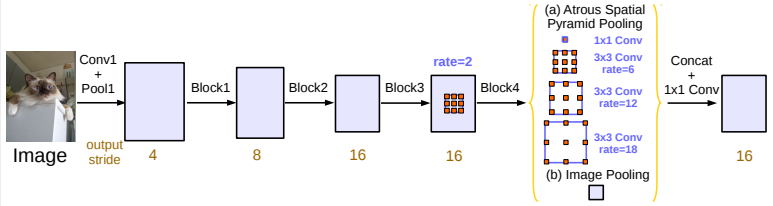

Concat ( $1 \times 1$卷积 ， 3个 $3 \times 3$空洞卷积(rate=6,12,18) +，pooled image feature) 并且每个卷积核都有256个且都有BN层。

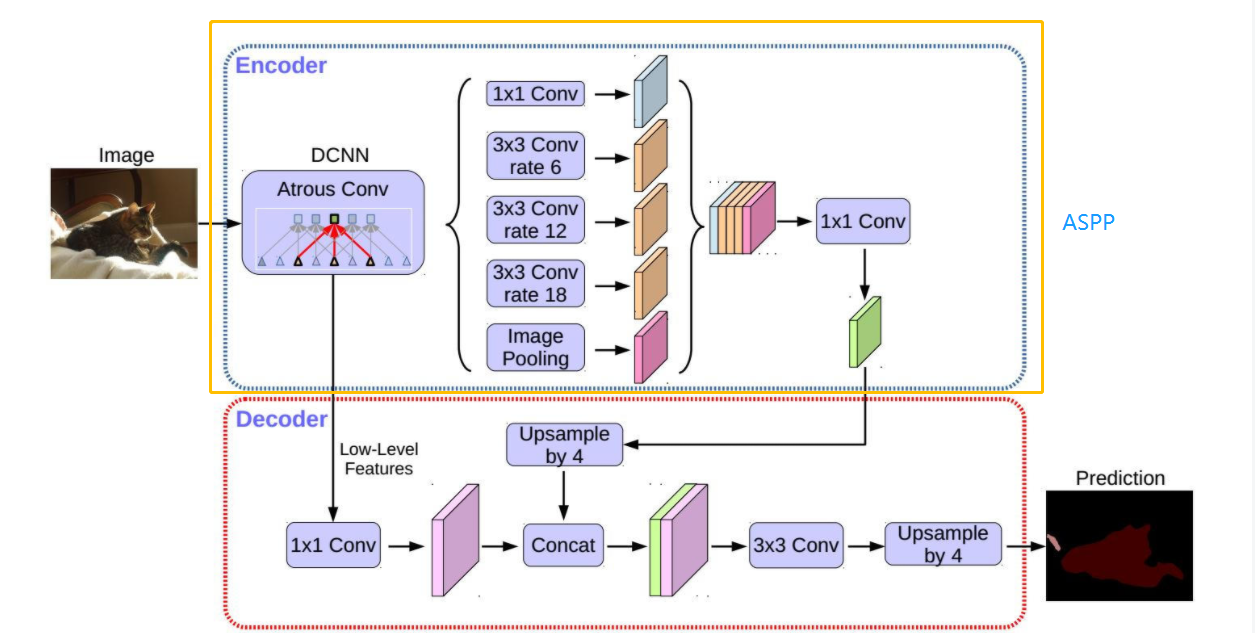

In [42]:
from torch import nn
import torch
import torch.nn.functional as F
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv,self).__init__(*modules)

class ASPPPooling(nn.Sequential):
    def __init__(self,in_channels,out_channels):
        super(ASPPPooling,self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels,out_channels,kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()        
        )
        
    def forward(self,x):
        size = x.shape[-2:]
        x = super(ASPPPooling,self).forward(x)
        return F.interpolate(x,size=size,mode='bilinear',align_corners=False)

class ASPP(nn.Module):
    def __init__(self,in_channels,out_channels,atrous_rates):
        super(ASPP,self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))
        
        rate1,rate2,rate3 = tuple(atrous_rates)
        modules.append(ASPPConv(in_channels,out_channels,rate1))
        modules.append(ASPPConv(in_channels,out_channels,rate2))
        modules.append(ASPPConv(in_channels,out_channels,rate3))
        modules.append(ASPPPooling(in_channels,out_channels))
        
        self.convs = nn.ModuleList(modules)
        
        self.project = nn.Sequential(
            nn.Conv2d(5*out_channels,out_channels,kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
    def forward(self,x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res,dim=1)
        return self.project(res)
    
aspp = ASPP(256,512,[6,12,18])
x = torch.rand(2,256,13,13)
print('ASPP Module: \n',aspp)
print(aspp(x).shape)

ASPP Module: 
 ASPP(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ASPPConv(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ASPPConv(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): ASPPConv(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(18, 18), dilation=(18, 18), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4)